<a href="https://colab.research.google.com/github/kouwis/UTKface-autoencoder/blob/master/UTKface_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Here is importing lib

from keras.layers import *
from keras.models import Model
import numpy as np
from matplotlib import pyplot as plt
import os
from keras.preprocessing.image import load_img,img_to_array
import zipfile
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [ ]:
#to get data from zipfile

filename = "crop_part1.zip"
with zipfile.ZipFile(filename, "r") as zip:
  zip.extractall()
  print("done")

done


In [ ]:
#show what is in data

base_dir = '/content/crop_part1'
big_data = os.listdir(base_dir)
big_data[:5]

['42_1_4_20170109002558079.jpg.chip.jpg',
 '49_0_1_20170111200637109.jpg.chip.jpg',
 '50_1_0_20170104184846062.jpg.chip.jpg',
 '2_1_4_20170103212142324.jpg.chip.jpg',
 '5_1_2_20161219192202650.jpg.chip.jpg']

In [ ]:
len(big_data)

9780

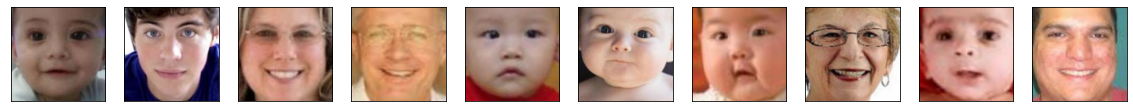

In [ ]:
#plotting some samples from data

n = 10
plt.figure(figsize=(20,4))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
  sample = np.random.choice(big_data)
  image = load_img(base_dir+"/"+sample)
  plt.imshow(image)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

In [ ]:
#split data to train and test

x_train, x_test = train_test_split(big_data,test_size=0.2,random_state=42)

In [ ]:
print(len(x_train))
print(len(x_test))

7824
1956


In [ ]:
#preprossing image and put it in array

x_train_img = []
for i in x_train:
  image = img_to_array(load_img(base_dir+"/"+i, target_size=(128,128,3))) / 255
  x_train_img.append(image)

x_test_img = []
for i in x_test:
  image = img_to_array(load_img(base_dir+"/"+i, target_size=(128,128,3))) / 255
  x_test_img.append(image)

x_train_img = np.array(x_train_img)
x_test_img = np.array(x_test_img)

In [ ]:
#put a noise in data

noise_factor = 0.5
x_train_noisy = x_train_img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_img.shape) 
x_test_noisy = x_test_img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_img.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

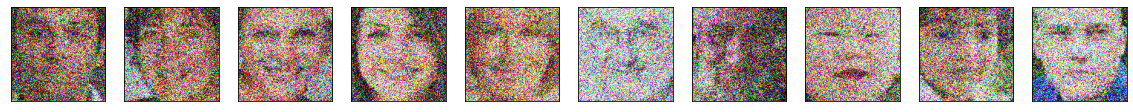

In [ ]:
#plotting some noise samples

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test_noisy[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

In [ ]:
print(type(x_train_noisy))
print(type(x_test_noisy))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
print(x_train_noisy.shape)
print(x_test_noisy.shape)

(7824, 128, 128, 3)
(1956, 128, 128, 3)


In [ ]:
#Using CNN

input_img = Input(shape=(128, 128, 3))

#Encoder

#Conv1
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

#Conv2
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

#Conv3
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

#Decoder

#Conv1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

#Conv2
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

#Conv3
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [ ]:
autoencoder = Model(input_img,decoded)
autoencoder.compile(optimizer="adam",loss="binary_crossentropy")
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0   

In [ ]:
autoencoder.fit(
    x_train_noisy,
    x_train_noisy,
    batch_size=200,
    epochs= 10,
    verbose=1,
    validation_data=[x_test_noisy,x_test_noisy]
)

Train on 7824 samples, validate on 1956 samples
Epoch 1/10
7824/7824 [==============================] - 65s 8ms/step - loss: 0.6660 - val_loss: 0.6482
Epoch 2/10
7824/7824 [==============================] - 51s 7ms/step - loss: 0.6460 - val_loss: 0.6449
Epoch 3/10
7824/7824 [==============================] - 51s 7ms/step - loss: 0.6436 - val_loss: 0.6430
Epoch 4/10
7824/7824 [==============================] - 51s 7ms/step - loss: 0.6422 - val_loss: 0.6423
Epoch 5/10
7824/7824 [==============================] - 51s 7ms/step - loss: 0.6418 - val_loss: 0.6417
Epoch 6/10
7824/7824 [==============================] - 51s 7ms/step - loss: 0.6414 - val_loss: 0.6411
Epoch 7/10
7824/7824 [==============================] - 51s 7ms/step - loss: 0.6407 - val_loss: 0.6419
Epoch 8/10
7824/7824 [==============================] - 51s 7ms/step - loss: 0.6403 - val_loss: 0.6402
Epoch 9/10
7824/7824 [==============================] - 51s 7ms/step - loss: 0.6401 - val_loss: 0.6400
Epoch 10/10
7824/7824 [==

In [ ]:
#predicting data

decoded_imgs = autoencoder.predict(x_test_img)

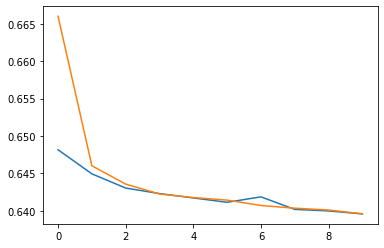

In [ ]:
#plotting history

plt.plot(autoencoder.history.history['val_loss'])
plt.plot(autoencoder.history.history['loss'])

In [ ]:
autoencoder.evaluate(x_test_img,decoded_imgs)

1956/1956 [==============================] - 5s 2ms/step


0.6101295020438898

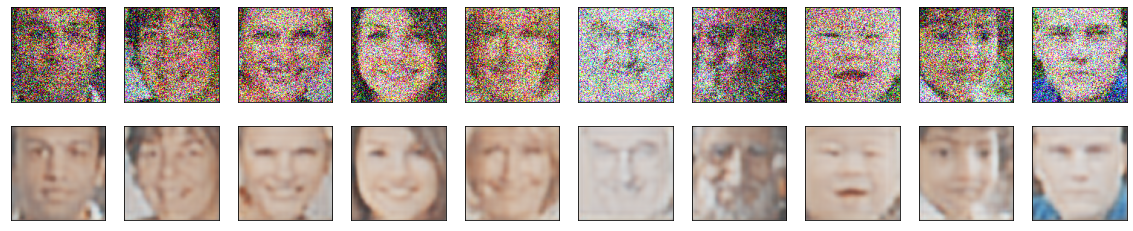

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()